# Advanced 한 내용
* DataGenerator 를 이용한 데이터 관리
* tf.session 을 이용한 훈련

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import datasets

import matplotlib.pyplot as plt
%matplotlib inline

## DataGenerator

1. 사이킷 런의 train_test_split 의 업그레이드된 버전
2. 셔플의 기능이 추가, 배치의 기능 추가 ( 모든 데이터를 병렬로 처리 )
3. label 의 관리가 필요 없다.

* from_tensor_slices() -> 데이터 세트 만들기
* shuffle() -> 섞기
* batch() -> 미니배치 만들기


In [31]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]

X_train, X_test = X_train / 255.0, X_test / 255.0

# tf.data 사용하기

In [32]:
# 데이터를 병렬로 불러올 수 있게 해준다.

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [33]:
# 훈련 데이터 generator 만들기

train_ds = train_ds.shuffle(1000) # 버피 사이즈 지정, 1000 정도가 제일 적당하다고 한다.
train_ds = train_ds.batch(32) # 미니 배치 사이즈

# 테스트 데이터 generator 만들기
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# train을 해줬으면 같은 방식으로 test도 해줘야 한다. 단, test 는 shuffle 할 필요가 없다. 이미 train 에서 shuffle 하기 때문에 test 를 shuffle 한다고 해서 출력값이 많이 변화되는건 아니다
test_ds = test_ds.batch(32)

# 시각화
* take() 함수를 이용하면 배치 사이즈만큼 가져온다.

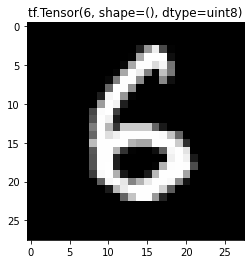

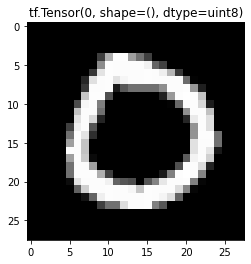

In [34]:
# 현재 각 배치의 형상 (32, 28, 28, 1)

for image_batch, label in train_ds.take(2):
  plt.title(str(label[0]))
  plt.imshow(image_batch[0, ..., 0], 'gray')
  plt.show()


# 케라스를 이용해서 CNN 레이어만들기

In [35]:
from tensorflow.keras import layers

# 레이어 쌓기
# 1. Input 형상, 분류할 클래스 개수 준비

input_shape = (28, 28, 1) # X_train[0].shape 를 해서 그 값을 넣어줘도 됨, 꼭 28,28,1 이 아니라는것을 알아둘 것
num_classes = 10

# 2. input 레이어 만들기

inputs = layers.Input(shape=input_shape)

# 3. 필요한 레이어 쌓기
# Feature Extraction 을 할 수 있는 CNN 레이어를 구성
# 레이어가 많아질수록 특징이 많아진다 ( 정확도가 높아지는 것은 아님 )
# 복잡한 이미지일수록 많은걸 볼 수 있게 되지만, 과대적합은 조심해야함


net = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='SAME')(inputs) # inputs 로 결과물을 흘려보내면 net이 그 결과물을 받는다
net = layers.Activation('relu')(net)
net = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME')(net) 
net = layers.Activation('relu')(net)
net = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Dropout(0.25)(net)

# Fully Connected (Dense, Affine)

net = layers.Flatten()(net) # 데이터를 쫙 펴준다.
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.25)(net)

# 출력층 설계
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

In [ ]:
model.summary()

In [14]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# model.fit(train_ds, epochs=1)

# 어제 했던거에서 train_ds -> 데이터셋을 사용했다는것만 달라짐

1875/1875 [==============================] - 7s 4ms/step - loss: 0.1258


# Tensorflow 를 중급자 수준으로 사용하기

# 최적화 함수 따로 빼기
* loss Function
* Optimizer

In [37]:
loss_object= tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

배치를 활용하고 있기 때문에 각 배치마다의 loss, accuracy 에 대한 평균을 구해준다.

즉, 평가 방법을 각 배치마다의 평균을 낸다.

In [38]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# 훈련 시키기
@tf.function - 그래프만 미리 만들어 놓고, 실제 학습이 시작되면 실행되는 함수 만들기

In [39]:
@tf.function # Tensorflow session(환경) 에서 작동되는 함수 만들기. 즉 훈련을 할 때만 실행된다.

# 미분이 필요

def train_step(images, labels): # 개인의 훈련루틴을 만들때 사용가능
  # 자동 미분 ( 오차 역전파 ) 수행하는 객체 생성
  with tf.GradientTape() as tape:
    predictions = model(images) # model 이 훈련 모드로 작동한다.
    loss = loss_object(labels, predictions) # 최초의 오차 -> 가 있어서 오차 역전파를 할 수 있다. 오차를 구하는 코드
    # loss 값에 대한 gradients( 기울기 ) 를 구해야 한다.

  # 미분적용하기
  gradients = tape.gradient(loss, model.trainable_variables)  # 오차역전파에 대한 기울기를 구했다.
  # 현재 가중치와 편향에 대한 오차값이 들어간다. ( loss ) 
  # 이전 층에 원래 흘러들어왔던 값 ( 매개변수 값, 훈련가능한 변수(weight, 편향) <- model.trainable_variables)
  
  # 기울기를 실제 적용 ( 최적화 loss 가 0 에 가까워지는 것)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # 구해진 기울기를 이용한 최적화


  # 배치평균 loss
  train_loss(loss)

  # 배치평균 정확도 구하기
  train_accuracy(labels, predictions) 

  


# 테스트 구현하기

In [40]:
@tf.function
def test_step(images, labels): # loss 가 적거나 acurracy 가 높으면 성공
  predictions = model(images)
  t_loss = loss_object(labels, predictions)
  
  test_loss(t_loss)
  test_accuracy(labels, predictions)


In [41]:
epochs = 5

for epoch in range(epochs):
  # 전체 데이터 훈련 ( take 를 안쓰면 전체데이터가 온다)  
  for images, labels in train_ds:
    train_step(images, labels)
  
  # 이어서 테스트하기
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)
    
  template = 'Epoch {}, Train Loss : {:.6f} / Train accuracy : {:.6f} --- Test Loss : {:.6f} / Test accuracy : {:.6f}'
  print(template.format(
      epoch + 1,
      train_loss.result(),
      train_accuracy.result() * 100,
      test_loss.result(),
      test_accuracy.result() * 100))

Epoch 1, Train Loss : 0.101356 / Train accuracy : 96.861664 --- Test Loss : 0.045953 / Test accuracy : 98.409996
Epoch 2, Train Loss : 0.068857 / Train accuracy : 97.882500 --- Test Loss : 0.037725 / Test accuracy : 98.715004
Epoch 3, Train Loss : 0.054302 / Train accuracy : 98.320557 --- Test Loss : 0.034610 / Test accuracy : 98.846664
Epoch 4, Train Loss : 0.045374 / Train accuracy : 98.581665 --- Test Loss : 0.033701 / Test accuracy : 98.904999
Epoch 5, Train Loss : 0.039111 / Train accuracy : 98.780998 --- Test Loss : 0.034994 / Test accuracy : 98.896004


In [42]:
from tensorflow.keras import layers

# 레이어 쌓기
# 1. Input 형상, 분류할 클래스 개수 준비

input_shape = (28, 28, 1) # X_train[0].shape 를 해서 그 값을 넣어줘도 됨, 꼭 28,28,1 이 아니라는것을 알아둘 것
num_classes = 10

# 2. input 레이어 만들기

inputs = layers.Input(shape=input_shape)

# 3. 필요한 레이어 쌓기
# Feature Extraction 을 할 수 있는 CNN 레이어를 구성
# 레이어가 많아질수록 특징이 많아진다 ( 정확도가 높아지는 것은 아님 )
# 복잡한 이미지일수록 많은걸 볼 수 있게 되지만, 과대적합은 조심해야함


net = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='SAME')(inputs) # inputs 로 결과물을 흘려보내면 net이 그 결과물을 받는다
net = layers.Activation('relu')(net)
net = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Dropout(0.25)(net)

net = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='SAME')(net) 
net = layers.Activation('relu')(net)
net = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPool2D((2,2))(net)
net = layers.Dropout(0.25)(net)

# Fully Connected (Dense, Affine)

net = layers.Flatten()(net) # 데이터를 쫙 펴준다.
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.25)(net)

# 출력층 설계
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs=net, name='Basic_CNN')

# Evaluating
* 학습된 모델 확인

In [43]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
hist = model.fit(train_ds, epochs=10) # 훈련 데이터에 대한 에폭 당 히스토리 확인 가능

Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1304 - acc: 0.9593
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0501 - acc: 0.9850
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0383 - acc: 0.9880
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0315 - acc: 0.9905
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0274 - acc: 0.9913
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0224 - acc: 0.9926
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0201 - acc: 0.9933
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0186 - acc: 0.9941
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0172 - acc: 0.9944
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0174 - acc: 0.9946


In [44]:
hist.history

{'acc': [0.9592999815940857,
  0.9850333333015442,
  0.9879999756813049,
  0.9905499815940857,
  0.991266667842865,
  0.9926166534423828,
  0.9932666420936584,
  0.9940666556358337,
  0.9944000244140625,
  0.994616687297821],
 'loss': [0.1303849220275879,
  0.050085801631212234,
  0.03834763914346695,
  0.03147687762975693,
  0.027434147894382477,
  0.02242027409374714,
  0.020079471170902252,
  0.01856851764023304,
  0.017239512875676155,
  0.017421746626496315]}

In [45]:
# 테스트 데이터에 대한 확인
# 실제 출시전 진행할 것
# train test 가 비슷하다면 99가 넘는다고 해도 과적합이라고 보기 힘들다
# 사람의 관점에서 보는것이기 때문에 주관적인 부분이 들어갈 수 밖에 없음

model.evaluate(test_ds)

313/313 [==============================] - 1s 3ms/step - loss: 0.0293 - acc: 0.9929


[0.02934885583817959, 0.992900013923645]